In [1]:
!pip install conllu

In [2]:

import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from conllu import parse
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# from conllu import parse

In [3]:
device = torch.device("cpu")
# if(torch.backends.mps.is_available()):
#     device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cpu')

File Paths

In [4]:

p=2
s=2
trainfilePath="en_atis-ud-train.conllu"
validationfilePath="en_atis-ud-dev.conllu"
testfilePayh="en_atis-ud-test.conllu"

Read Train, Test, validation data

In [5]:
warnings.filterwarnings("ignore")
torch.manual_seed(1)
with open(trainfilePath) as f:
    train_data = parse(f.read())
with open(validationfilePath) as f:
    dev_data = parse(f.read())
with open(testfilePayh) as f:
    test_data = parse(f.read())

Prepate datasets

In [6]:
# train_data
def prepare_datasets(dataset):
    # dict1={}
    mod_data = []
    for idx in range(len(dataset)):
        tempword = []
        temptag = []
        for jdx in range(len(dataset[idx])):
            tempword.append(dataset[idx][jdx]["form"])
            temptag.append(dataset[idx][jdx]["upos"])
            # if dataset[idx][jdx]["upos"] not in dict1:
            #     dict1[dataset[idx][jdx]["upos"]]=1


        mod_data.append([tempword, temptag])
    return mod_data
mod_train_data = prepare_datasets(train_data)
mod_dev_data = prepare_datasets(dev_data)
mod_test_data = prepare_datasets(test_data)


Number of sentense in each catogery

In [7]:
print(f"Number of training examples: {len(mod_train_data)}")
print(f"Number of validation examples: {len(mod_dev_data)}")
print(f"Number of testing examples: {len(mod_test_data)}")

Number of training examples: 4274
Number of validation examples: 572
Number of testing examples: 586


 create vocab for train data

In [8]:
# create vocab for train
words_list = [sublist[0] for sublist in mod_train_data]
word_vocab = torchtext.vocab.build_vocab_from_iterator(words_list, min_freq=2)
word_vocab.insert_token("<unk>", 0)
word_vocab.set_default_index(word_vocab["<unk>"])

tags_list = [sublist[1] for sublist in mod_train_data]
tag_vocab = torchtext.vocab.build_vocab_from_iterator(tags_list)
# tag_vocab.insert_token("<unk>", 0)
# tag_vocab.set_default_index(tag_vocab["<unk>"])


itos_mapping = tag_vocab.get_stoi()

# Print the vocabulary
print(itos_mapping)
print(f"Unique words: {len(word_vocab)}")
print(f"Unique tags: {len(tag_vocab)}")

{'PART': 11, 'ADV': 10, 'CCONJ': 9, 'INTJ': 12, 'AUX': 6, 'VERB': 3, 'NUM': 8, 'NOUN': 2, 'ADJ': 7, 'ADP': 1, 'PRON': 5, 'DET': 4, 'PROPN': 0}
Unique words: 601
Unique tags: 13


Padding

In [9]:
X_train = [sublist[0] for sublist in mod_train_data]
Y_train=[sublist[1] for sublist in mod_train_data]


X_valid = [sublist[0] for sublist in mod_dev_data]
Y_valid=[sublist[1] for sublist in mod_dev_data]



X_test = [sublist[0] for sublist in mod_test_data]
Y_test=[sublist[1] for sublist in mod_test_data]



def padding(X,start_symbol,end_symbol):
  modified_list_of_lists = [[start_symbol] * p + sublist + [end_symbol] * s for sublist in X]
  return modified_list_of_lists





def replace_word_in_lists(list_of_lists, X_list_of_list, word_to_replace):
    updated_list_of_lists = []
    updated_X_list_of_list = []

    for sub_list, X_sub_list in zip(list_of_lists, X_list_of_list):
        updated_sub_list = []
        updated_sub_list_X = []

        for word, X_word in zip(sub_list, X_sub_list):
            if word == word_to_replace:
                # Skip adding word_to_replace and its corresponding element
                continue

            updated_sub_list.append(word)
            updated_sub_list_X.append(X_word)

        updated_list_of_lists.append(updated_sub_list)
        updated_X_list_of_list.append(updated_sub_list_X)

    return updated_list_of_lists, updated_X_list_of_list

Y_valid,X_valid=replace_word_in_lists(Y_valid,X_valid,'SYM')


In [10]:
X_train=padding(X_train,"<s>","</s>")



X_valid=padding(X_valid,"<s>","</s>")


X_test=padding(X_test,"<s>","</s>")


Embeding

In [11]:
from ast import keyword
def sequence_to_idx(X, ix):
  encoded_X=[]
  for sent in X:
    ans=[]


    for word in sent:
      try:
        ans.append(ix[word])
      except KeyError:
        ans.append(0)

    encoded_X.append(ans)
  return encoded_X

def sequence_to_idx_user(X, ix):
  encoded_X=[]

  for word in X:
    try:
      encoded_X.append(ix[word])
    except KeyError:
      encoded_X.append(0)
  return encoded_X



X_train_encoded=sequence_to_idx(X_train,word_vocab)
Y_train_encoded=sequence_to_idx(Y_train,tag_vocab)



X_valid_encoded=sequence_to_idx(X_valid,word_vocab)
Y_valid_encoded=sequence_to_idx(Y_valid,tag_vocab)



X_test_encoded=sequence_to_idx(X_test,word_vocab)
Y_test_encoded=sequence_to_idx(Y_test,tag_vocab)






One-hot-encodeing

In [12]:
def one_hot_encodeing(X,vector_size):
  one_hot_encoding_vec=[]
  for vec in X:
    one_hot_of_sentense=[]
    for idx in vec:
      vector = [1 if i == idx else 0 for i in range(vector_size)]
      one_hot_of_sentense.append(vector)
    one_hot_encoding_vec.append(one_hot_of_sentense)
  return one_hot_encoding_vec

def one_hot_encodeing_user(X,vector_size):
  one_hot_encoding_vec=[]

  for idx in X:
    vector = [1 if i == idx else 0 for i in range(vector_size)]
    one_hot_encoding_vec.append(vector)
  return one_hot_encoding_vec






In [13]:
X_train_one_hot_encoded=one_hot_encodeing(X_train_encoded,len(word_vocab))
y_train_one_hot_encoded=one_hot_encodeing(Y_train_encoded,len(tag_vocab))



X_valid_one_hot_encoded=one_hot_encodeing(X_valid_encoded,len(word_vocab))
y_valid_one_hot_encoded=one_hot_encodeing(Y_valid_encoded,len(tag_vocab))




X_test_one_hot_encoded=one_hot_encodeing(X_test_encoded,len(word_vocab))
y_test_one_hot_encoded=one_hot_encodeing(Y_test_encoded,len(tag_vocab))

make P+1+S length input

In [14]:
def create_matrix(X, Y):
    X_mat = []
    Y_mat = []
    for x, y in zip(X, Y):
        sublists = [x[i:i+p+s+1] for i in range(len(x) - (p+s+1) + 1)]
        sublist2 = [y[i] for i in range(len(y))]  # Adjust range for Y_mat
        X_mat.extend(sublists)
        Y_mat.extend(sublist2)
    return X_mat, Y_mat



X_mat, Y_mat = create_matrix(X_train_one_hot_encoded, y_train_one_hot_encoded)

X_mat_valid, Y_mat_valid = create_matrix(X_valid_one_hot_encoded, y_valid_one_hot_encoded)


X_mat_test, Y_mat_test = create_matrix(X_test_one_hot_encoded, y_test_one_hot_encoded)


In [15]:
def create_matrix_user(X):
    X_mat = []


    sublists = [X[i:i+p+s+1] for i in range(len(X) - (p+s+1) + 1)]
    X_mat.extend(sublists)

    return X_mat

In [16]:
X_train_input = np.array(X_mat)
Y_train_input = np.array(Y_mat)


X_valid_input = np.array(X_mat_valid)
Y_valid_input = np.array(Y_mat_valid)


X_test_input = np.array(X_mat_test)
Y_test_input = np.array(Y_mat_test)

print("train")
print(X_train_input.shape)
print(Y_train_input.shape)


print("valid")
print(X_valid_input.shape)
print(Y_valid_input.shape)



print("test")
print(X_test_input.shape)
print(Y_test_input.shape)



train
(48655, 5, 601)
(48655, 13)
valid
(6642, 5, 601)
(6642, 13)
test
(6580, 5, 601)
(6580, 13)


In [17]:
embedding_dim = 601

hidden_dim = 128
output_dim = 13  # Number of POS tags
batch_size = 32
num_epochs = 50
L_R=0.0001

# FFNN

In [18]:
# Define the Feed Forward Neural Network model
class FFNN_POS_Tagger(nn.Module):
    def __init__(self, embedding_dim, p, s, hidden_dim, output_dim):
        super(FFNN_POS_Tagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.p = p
        self.s = s
        self.input_dim = embedding_dim * (p + s + 1)
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, inputs):
        x = inputs.view(-1, self.input_dim)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x





# Instantiate the model, loss function, and optimizer
model = FFNN_POS_Tagger(embedding_dim, p, s, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=L_R)

X_train_tensor = torch.tensor(X_train_input)
y_train_tensor = torch.tensor(Y_train_input)
X_valid_tensor = torch.tensor(X_valid_input)
y_valid_tensor = torch.tensor(Y_valid_input)
X_test_tensor = torch.tensor(X_test_input)
y_test_tensor = torch.tensor(Y_test_input)



In [19]:


train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
validation_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=1)

In [20]:
def transform_to_one_hot_ffnn(tensor):
    """
    Transforms each row in the given PyTorch tensor to a one-hot encoding format,
    where the maximum value in each row is set to 1 and all other values are set to 0.

    Args:
    - tensor (torch.Tensor): A PyTorch tensor containing float values.

    Returns:
    - torch.Tensor: The transformed tensor with one-hot encoding format.
    """
    transformed_tensor = torch.zeros_like(tensor)
    max_values, max_indices = torch.max(tensor, dim=1)
    for i in range(len(tensor)):
        transformed_tensor[i, max_indices[i]] = 1.
    return transformed_tensor
def transform_to_one_hot_user_ffnn(tensor):
    max_index = torch.argmax(tensor)
    return max_index

def howmany_equal_ffnn(predicted_val, targets):
    t = 0
    for t1, t2 in zip(predicted_val, targets):
        if torch.all(t1.eq(t2)):
            t += 1
    return t

In [21]:
train_loader

In [22]:
def train_model_ffnn(model,criterion,optimizer,num_epochs,train_loader,validation_loader):
  epoch_v=[]
  val_v=[]
  loss_v=[]

  for epoch in range(num_epochs):
      model.train()

      for inputs, targets in train_loader:
          optimizer.zero_grad()
          inputs = inputs.float()  # Convert input to float data type
          outputs = model(inputs)
          targets = targets.float()
          loss = criterion(outputs, targets)

          loss.backward()
          optimizer.step()

      # Validation loop
      model.eval()
      with torch.no_grad():
          total_val = 0
          correct_val = 0
          loss_val=0


          for inputs, targets in validation_loader:
              inputs = inputs.float()  # Convert input to float data type
              outputs = model(inputs)
              targets = targets.float()


              predicted_val = transform_to_one_hot_ffnn(outputs)
              loss = criterion(outputs, targets)
              loss_val=loss_val+loss.item()

              total_val += targets.size(0)
              # correct_val += (predicted_val == targets).sum().item()
              correct_match= howmany_equal_ffnn(predicted_val, targets)
              correct_val=correct_val+correct_match




          accuracy_val = correct_val / total_val
          loss_val=loss_val/total_val


          epoch_v.append(epoch+1)
          val_v.append(accuracy_val)
          loss_v.append(loss_val)
          print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy_val}')
  return epoch_v,val_v,loss_v

epoch_v,val_v,loss_v=train_model_ffnn(model,criterion,optimizer,num_epochs,train_loader,validation_loader)


Epoch 1/50, Validation Accuracy: 0.8589280337247817
Epoch 2/50, Validation Accuracy: 0.9396266184884071
Epoch 3/50, Validation Accuracy: 0.9601023788015658
Epoch 4/50, Validation Accuracy: 0.9732008431195424
Epoch 5/50, Validation Accuracy: 0.9787714543812105
Epoch 6/50, Validation Accuracy: 0.9796747967479674
Epoch 7/50, Validation Accuracy: 0.9787714543812105
Epoch 8/50, Validation Accuracy: 0.980126467931346
Epoch 9/50, Validation Accuracy: 0.9808792532369768
Epoch 10/50, Validation Accuracy: 0.9799759108702198
Epoch 11/50, Validation Accuracy: 0.980126467931346
Epoch 12/50, Validation Accuracy: 0.9817825956037338
Epoch 13/50, Validation Accuracy: 0.9820837097259861
Epoch 14/50, Validation Accuracy: 0.98193315266486
Epoch 15/50, Validation Accuracy: 0.9813309244203553
Epoch 16/50, Validation Accuracy: 0.981029810298103
Epoch 17/50, Validation Accuracy: 0.9822342667871123
Epoch 18/50, Validation Accuracy: 0.9814814814814815
Epoch 19/50, Validation Accuracy: 0.9807286961758507
Epoch 2

In [23]:
print(epoch_v)
print(val_v)
print(loss_v)
torch.save(model.state_dict(), 'ffnn_model2.pt')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[0.8589280337247817, 0.9396266184884071, 0.9601023788015658, 0.9732008431195424, 0.9787714543812105, 0.9796747967479674, 0.9787714543812105, 0.980126467931346, 0.9808792532369768, 0.9799759108702198, 0.980126467931346, 0.9817825956037338, 0.9820837097259861, 0.98193315266486, 0.9813309244203553, 0.981029810298103, 0.9822342667871123, 0.9814814814814815, 0.9807286961758507, 0.981029810298103, 0.9805781391147245, 0.9798253538090936, 0.981029810298103, 0.9817825956037338, 0.981029810298103, 0.9814814814814815, 0.9817825956037338, 0.981029810298103, 0.9816320385426076, 0.9808792532369768, 0.9795242396868413, 0.981029810298103, 0.9813309244203553, 0.9811803673592292, 0.9807286961758507, 0.9795242396868413, 0.9802770249924722, 0.9784703402589582, 0.981029810298103, 0.9802770249924722, 0.980126467931346,

In [24]:
def plot_graph_ffnn(epoch_v, loss_v,val_v):
  plt.figure(figsize=(10, 5))
  plt.plot(epoch_v, loss_v, marker='o', color='green', label='Validation Loss')
  plt.title('Validation Loss vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()




  # Plotting accuracy vs epoch
  plt.figure(figsize=(10, 5))
  plt.plot(epoch_v, val_v, marker='o', color='blue', label='Validation Accuracy')
  plt.title('Validation Accuracy vs Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

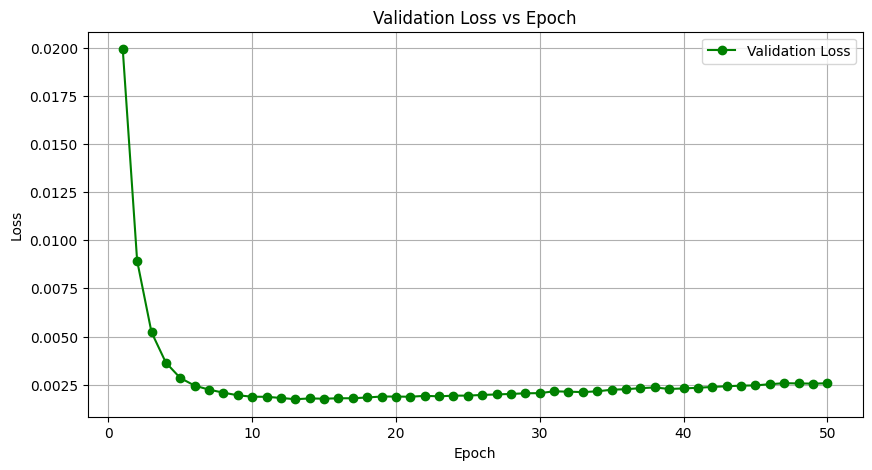

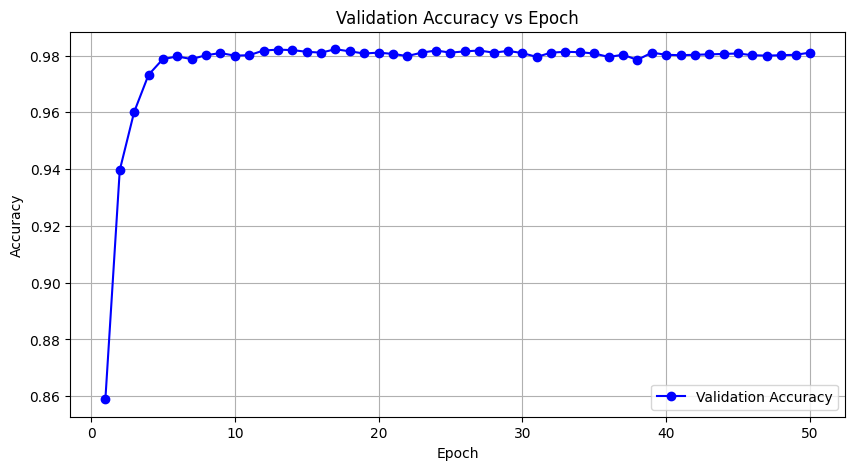

In [25]:
plot_graph_ffnn(epoch_v, loss_v,val_v)

test accuracy


In [26]:
def test_model_ffnn(model,test_loader):
  empty_shape = (0, 13)
  pred_vector= torch.empty(empty_shape)
  model.eval()
  with torch.no_grad():
      total_test = 0
      correct_test = 0

      for inputs, target in test_loader:

          inputs = inputs.float()   # Convert input to float data type
          outputs = model(inputs)


          predicted_val = transform_to_one_hot_ffnn(outputs)
          pred_vector = torch.cat((pred_vector, predicted_val), dim=0)
          total_test += 1
          correct_match= howmany_equal_ffnn(predicted_val, target)

          correct_test += correct_match
      accuracy_test = correct_test / total_test
      print(f'Test Accuracy: {accuracy_test}')
  return pred_vector




In [27]:
pred_vector=test_model_ffnn(model,test_loader)

Test Accuracy: 0.9820668693009118


In [28]:
print(pred_vector.shape)
print(y_test_tensor.shape)

pred_vector = torch.argmax(pred_vector, dim=1)
y_test_tensor = torch.argmax(y_test_tensor, dim=1)

torch.Size([6580, 13])
torch.Size([6580, 13])


In [29]:
import pandas as pd

# Calculate confusion matrix
def confusion_matrix_ffnn(y_test_tensor,pred_vector):
  conf_matrix = confusion_matrix(y_test_tensor, pred_vector)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()



  print("Classification Report :")
  report = classification_report(y_test_tensor, pred_vector, output_dict=True)
  df = pd.DataFrame(report).transpose()
  cm = sns.light_palette("green", as_cmap=True)
  styled_table = df.style.background_gradient(cmap=cm)
  return styled_table,conf_matrix

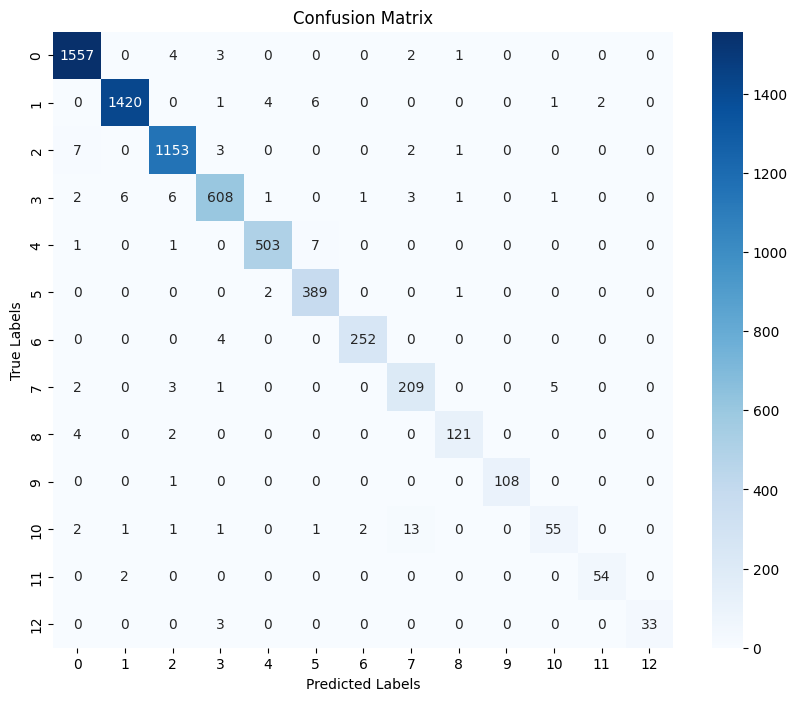

Classification Report :


,precision,recall,f1-score,support
0,0.988571,0.993618,0.991088,1567.000000
1,0.993702,0.990237,0.991966,1434.000000
2,0.984629,0.988851,0.986735,1166.000000
3,0.974359,0.966614,0.970471,629.000000
4,0.986275,0.982422,0.984344,512.000000
5,0.965261,0.992347,0.978616,392.000000
6,0.988235,0.984375,0.986301,256.000000
7,0.912664,0.950000,0.930958,220.000000
8,0.968000,0.952756,0.960317,127.000000
9,1.000000,0.990826,0.995392,109.000000


In [30]:
styled_table,conf_matrix=confusion_matrix_ffnn(y_test_tensor,pred_vector)
styled_table

In [31]:
print(conf_matrix)

[[1557    0    4    3    0    0    0    2    1    0    0    0    0]
 [   0 1420    0    1    4    6    0    0    0    0    1    2    0]
 [   7    0 1153    3    0    0    0    2    1    0    0    0    0]
 [   2    6    6  608    1    0    1    3    1    0    1    0    0]
 [   1    0    1    0  503    7    0    0    0    0    0    0    0]
 [   0    0    0    0    2  389    0    0    1    0    0    0    0]
 [   0    0    0    4    0    0  252    0    0    0    0    0    0]
 [   2    0    3    1    0    0    0  209    0    0    5    0    0]
 [   4    0    2    0    0    0    0    0  121    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0  108    0    0    0]
 [   2    1    1    1    0    1    2   13    0    0   55    0    0]
 [   0    2    0    0    0    0    0    0    0    0    0   54    0]
 [   0    0    0    3    0    0    0    0    0    0    0    0   33]]


In [32]:


reverse_tag_vocab = {v: k for k, v in tag_vocab.get_stoi().items()}




def calculate_ans_print_class_accuracy(confusion_matrix):
    diagonal = confusion_matrix.diagonal()
    class_totals = confusion_matrix.sum(axis=1)
    class_accuracy = np.nan_to_num(diagonal / class_totals)
    class_accuracy_data = [{"Class": reverse_tag_vocab[class_idx], "Accuracy": accuracy} for class_idx, accuracy in enumerate(class_accuracy)]
    class_accuracy_df = pd.DataFrame(class_accuracy_data)
    print("class wise accuracy on test data")
    return class_accuracy_df


# Print DataFrame
class_accuracy_df=calculate_ans_print_class_accuracy(conf_matrix)
class_accuracy_df


class wise accuracy on test data


,Class,Accuracy
0,PROPN,0.993618
1,ADP,0.990237
2,NOUN,0.988851
3,VERB,0.966614
4,DET,0.982422
5,PRON,0.992347
6,AUX,0.984375
7,ADJ,0.950000
8,NUM,0.952756
9,CCONJ,0.990826


In [33]:
y_test_tensor

tensor([5, 6, 4,  ..., 0, 9, 0])

In [37]:
def find_tags_ffnn(data,model,tag_vocab):
  ans=[]
  model.eval()
  with torch.no_grad():

      for inputs1 in data:

          inputs1 = inputs1.float()   # Convert input to float data type
          outputs1 = model(inputs1)
          predicted_val1 = transform_to_one_hot_user_ffnn(outputs1)
          tag = next((key for key, value in tag_vocab.get_stoi().items() if value == predicted_val1), None)
          ans.append(tag)
  return ans


In [43]:
def run_model_on_user_input_ffnn(model,word_vocab,tag_vocab,user_input):
  print("Your Sent:", user_input)
  input= user_input.lower().split()
  # print(input)
  input_p=["<s>"] * p + input + ["</s>"] * s

  input_encoded=sequence_to_idx_user(input_p,word_vocab)

  input_one_hot_encoded=one_hot_encodeing_user(input_encoded,len(word_vocab))

  input_mat_test = create_matrix_user(input_one_hot_encoded)

  user_input = np.array(input_mat_test)
  user_input_tensor = torch.tensor(user_input)

  user_input_loader = DataLoader(user_input_tensor, batch_size=1)


  ans=find_tags_ffnn(user_input_loader,model,tag_vocab)
  print(input)
  print(ans)

run_model_on_user_input_ffnn(model,word_vocab,tag_vocab,user_input ="i want an early upgrade")

run_model_on_user_input_ffnn(model,word_vocab,tag_vocab,user_input ="An apple a day keeps the doctor away")

Your Sent: i want an early upgrade
['i', 'want', 'an', 'early', 'upgrade']
['PRON', 'VERB', 'DET', 'ADJ', 'NOUN']
Your Sent: An apple a day keeps the doctor away
['an', 'apple', 'a', 'day', 'keeps', 'the', 'doctor', 'away']
['DET', 'ADJ', 'DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'PROPN']


In [44]:
# user_input1 ="An apple a day keeps the doctor away"
# print("Your Sent:", user_input1)
# input= user_input1.lower().split()
# # print(input)
# input_p=["<s>"] * p + input + ["</s>"] * s

# input_encoded=sequence_to_idx_user(input_p,word_vocab)
# input_one_hot_encoded=transform_to_one_hot_user(input_encoded,len(word_vocab))
# input_mat_test = create_matrix_user(input_one_hot_encoded)

# user_input = np.array(input_mat_test)
# user_input_tensor = torch.tensor(user_input)

# user_input_loader = DataLoader(user_input_tensor, batch_size=1)


# ans=find_tags(user_input_loader,model)
# print(input)
# print(ans)

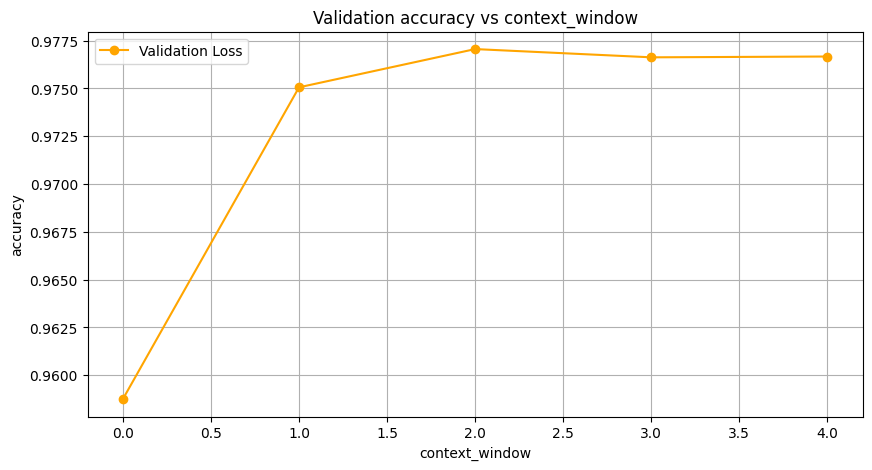

In [45]:
accuracy=[0.9587473652514303, 0.9750522396868413, 0.9770522396868413, 0.9766208973200843, 0.9766636555254441]
p_s=[0, 1, 2, 3, 4]

plt.figure(figsize=(10, 5))
plt.plot(p_s, accuracy, marker='o', color='orange', label='Validation Loss')
plt.title('Validation accuracy vs context_window')
plt.xlabel('context_window')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()